In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, RationalQuadratic, WhiteKernel, ConstantKernel as C


In [2]:
np.random.seed(10)
tag = 'fcn_1'

# toy function (we will assume this is a black box) -- this is where real data would be imported
def get_stiff(X):
	num_pts = X.shape[0]	
	# fcn_1 
	y =  np.sin(X[:,0])*np.sin(X[:,1]) + 1.0/10.0*X[:,0]**2.0 + np.random.normal(0,2,num_pts) + 100
	# fcn 2 
	#y = np.random.normal(0,50,num_pts) + 200 
	# fcn 3
	#y = (X[:,0] - 5.0)**2.0 + (X[:,1] - 5.0)**2.0 + np.random.normal(0,5,num_pts) + 50 + .15*X[:,0]*X[:,1]
	return y


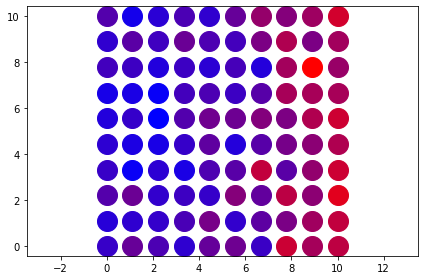

In [10]:
# sample the function (w/ real data this would just be import data)
# --> make a grid of points 
x1 = np.linspace(0,10,10)
x2 = np.linspace(0,10,10)
xv, yv = np.meshgrid(x1, x2)
num_pts = xv.shape[0]*xv.shape[1]
X = np.zeros((num_pts,2))
X[:,0] = np.reshape(xv,(-1,1))[:,0]
X[:,1] = np.reshape(yv,(-1,1))[:,0]

# --> sample the function
y = get_stiff(X)

plt.figure()
mi = np.min(y)
ma = np.max(y)

for kk in range(0,X.shape[0]):
	val = (y[kk] - mi) / (ma - mi)
	plt.plot(X[kk,0],X[kk,1],'o',color=(val, 0, 1.0 - val),markersize=20)

ax = plt.gca()
ax.axis('equal')
plt.tight_layout()
plt.savefig(tag + '_stiffness_distribution')

In [6]:
# define and train a GPR model 
kernel = 1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-1, 10.0))
gp = GaussianProcessRegressor(kernel=kernel,alpha=20.0)
gp.fit(X, y)

GaussianProcessRegressor(alpha=20.0, copy_X_train=True,
                         kernel=1**2 * RBF(length_scale=1),
                         n_restarts_optimizer=0, normalize_y=False,
                         optimizer='fmin_l_bfgs_b', random_state=None)

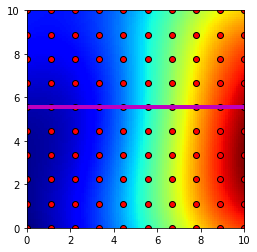

In [7]:
# visualize the GPR model
x1 = np.linspace(0,10,100)
x2 = np.linspace(0,10,100)
xv, yv = np.meshgrid(x1, x2)
num_pts = xv.shape[0]*xv.shape[1]
X_interp = np.zeros((num_pts,2))
X_interp[:,0] = np.reshape(xv,(-1,1))[:,0]
X_interp[:,1] = np.reshape(yv,(-1,1))[:,0]

y_mean, y_std = gp.predict(X_interp, return_std=True)

plt.figure()
plt.imshow(y_mean.reshape(100,100),origin='lower',interpolation='nearest',cmap='jet',extent=[0,10,0,10])
plt.plot(X[:,0],X[:,1],'ro',markeredgecolor='k')
plt.plot([0,10],[5.55,5.55],'m-',linewidth=4)
plt.savefig('gpr_interpolation')


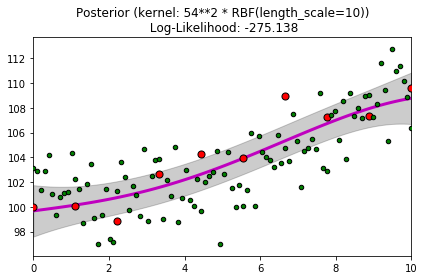

In [9]:
# visualize in 1D 
actual_y = get_stiff(X_interp)
st = 100*5
end = 100*6


plt.figure()
plt.plot(X_interp[st:end,0], y_mean[st:end], 'm', lw=3, zorder=9)
plt.fill_between(X_interp[st:end,0], y_mean[st:end] - y_std[st:end], y_mean[st:end] + y_std[st:end],
				 alpha=0.2, color='k')
plt.scatter(X[50:60,0], y[50:60], c='r', s=50, zorder=10, edgecolors=(0, 0, 0))
plt.scatter(X_interp[st:end,0], actual_y[st:end], c='g', s=20, zorder=20, edgecolors=(0, 0, 0))
plt.xlim(0, 10)
#plt.ylim(-3, 3)
plt.title("Posterior (kernel: %s)\n Log-Likelihood: %.3f"
		  % (gp.kernel_, gp.log_marginal_likelihood(gp.kernel_.theta)),
		  fontsize=12)
plt.tight_layout()
plt.savefig('compare_to_real')
